In [14]:
# Import necessary libraries, taken from recitation 10
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split, KFold, LeaveOneOut, cross_val_predict

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.metrics import mean_squared_error

# Settings
sns.set(style="whitegrid")

### Converting Categorical Variables

In [15]:
df = pd.read_csv('complete_data.csv')

# dummy variable approach for income level classification, updated from recit 10
df_dummy = pd.get_dummies(df['classification'], prefix='classification', drop_first = True)

df = pd.concat([df, df_dummy], axis=1) # add encoded variables to original data frame

# dummy variable approach for world regions
#df_dummy = pd.get_dummies(df['World_Region'], prefix='World_Region', drop_first = True)


# I chose to drop World_Region_North America specifically because it had a high VIF score
df_dummy = pd.get_dummies(df['World_Region'], prefix='World_Region', drop_first = False)
df_dummy = df_dummy.drop(columns=['World_Region_North America'])

df = pd.concat([df, df_dummy], axis=1)

df.to_csv("complete_data_encoded.csv")




* As I have only 4 income classifications and 6 world regions it is possible to use one hot encoding or dummy variable approach since I do not have too many variables.

* Among the two, I chose to use dummy variable approach because I am using a regression model.

### Keep Columns Relevant to ML

In [16]:
# unused columns for ML are dropped for clarity

#df now has all features and the target column, including encoded categorical variables
df = df.drop(columns=["Entity",
    "Year",
    "classification",
    "World_Region",
    "Population",

    "Math_PISA_Female",
    "Math_PISA_Male",
    "Math_PISA_Total",

    "Read_PISA_Female",
    "Read_PISA_Male",
    "Read_PISA_Total",

    "Sci_PISA_Female",
    "Sci_PISA_Male",
    "Sci_PISA_Total" ,


    'PISA_Girls_Average',
    'PISA_Boys_Average',

    'Mean_School_Years_M',
    'Mean_School_Years_F',
    'Unnamed: 0'])


df.dtypes

,0
EduSpend_GDP,float64
GDP_PPP_perCapita,float64
Gini_Coefficient,float64
Gender_Inequality,float64
GovEduSpend_Pct,float64
Avg_School_Years,float64
Expected_School_Years,float64
HDI,float64
Corruption_Index,float64
PISA_Total_Average,float64


### Apply Standardization


In [17]:
dummyVar_cols = [
    "classification_Low-income countries",
    "classification_Lower-middle-income countries",
    "classification_Upper-middle-income countries",

    "World_Region_Asia",
    "World_Region_Europe",
    #"World_Region_North America",
    'World_Region_Africa',
    "World_Region_Oceania",
    "World_Region_South America",]


pisa_before_std= df[['PISA_Total_Average']]

# creating a list of numerical columns to standardize, excluding encoded categorical variables
numerical_columns = []
for column in df.columns:
    if column not in dummyVar_cols:
      numerical_columns.append(column)

print(numerical_columns) # to check the column names

scaler = StandardScaler()

# only numerical columns are scaled
scaled_values = scaler.fit_transform(df[numerical_columns])

# partial data frame of scaled values with same column names
df_scaled = pd.DataFrame(scaled_values, columns=numerical_columns, index=df.index)

# scaled and encoded values are combined back
df = pd.concat([ df_scaled, df[dummyVar_cols]], axis=1)
#df['PISA_Total_Average'],

df = df * 1 # used to convert boolean to integer,
            # it will be useful later when calculating VIF for dummy variable encoded columns

df.head()
#df.describe()


['EduSpend_GDP', 'GDP_PPP_perCapita', 'Gini_Coefficient', 'Gender_Inequality', 'GovEduSpend_Pct', 'Avg_School_Years', 'Expected_School_Years', 'HDI', 'Corruption_Index', 'PISA_Total_Average']


,EduSpend_GDP,GDP_PPP_perCapita,Gini_Coefficient,Gender_Inequality,GovEduSpend_Pct,Avg_School_Years,Expected_School_Years,HDI,Corruption_Index,PISA_Total_Average,classification_Low-income countries,classification_Lower-middle-income countries,classification_Upper-middle-income countries,World_Region_Asia,World_Region_Europe,World_Region_Africa,World_Region_Oceania,World_Region_South America
0,-0.856356,-1.068267,-0.763326,0.184493,-0.607354,-0.611713,-1.734980,-1.292986,1.340299,-1.229175,0,1,0,0,1,0,0,0
1,-1.078962,-1.016115,-0.595039,0.078031,-0.607354,-0.526086,-1.441734,-1.056468,1.357391,-1.161412,0,1,0,0,1,0,0,0
2,-1.038373,-0.957632,-0.731048,-0.040955,-0.757809,-0.442518,-0.929942,-0.778817,1.278768,-1.093649,0,1,0,0,1,0,0,0
3,-0.832733,-0.885472,-0.824459,-0.448015,-0.665533,-0.311499,-0.579946,-0.532016,1.394993,-1.025885,0,0,1,0,1,0,0,0
4,-0.948702,-0.847682,-0.932624,-0.416702,-0.543714,-0.064737,0.464697,-0.151531,1.425759,-0.841099,0,0,1,0,1,0,0,0


* Standardization is applied to continuous variables including target variable, dummy variable encoded ones are exempt.

* Boolean values are converted to integer 0 and 1 for calculating VIF in later cells.

### Checking for Multicollinearity

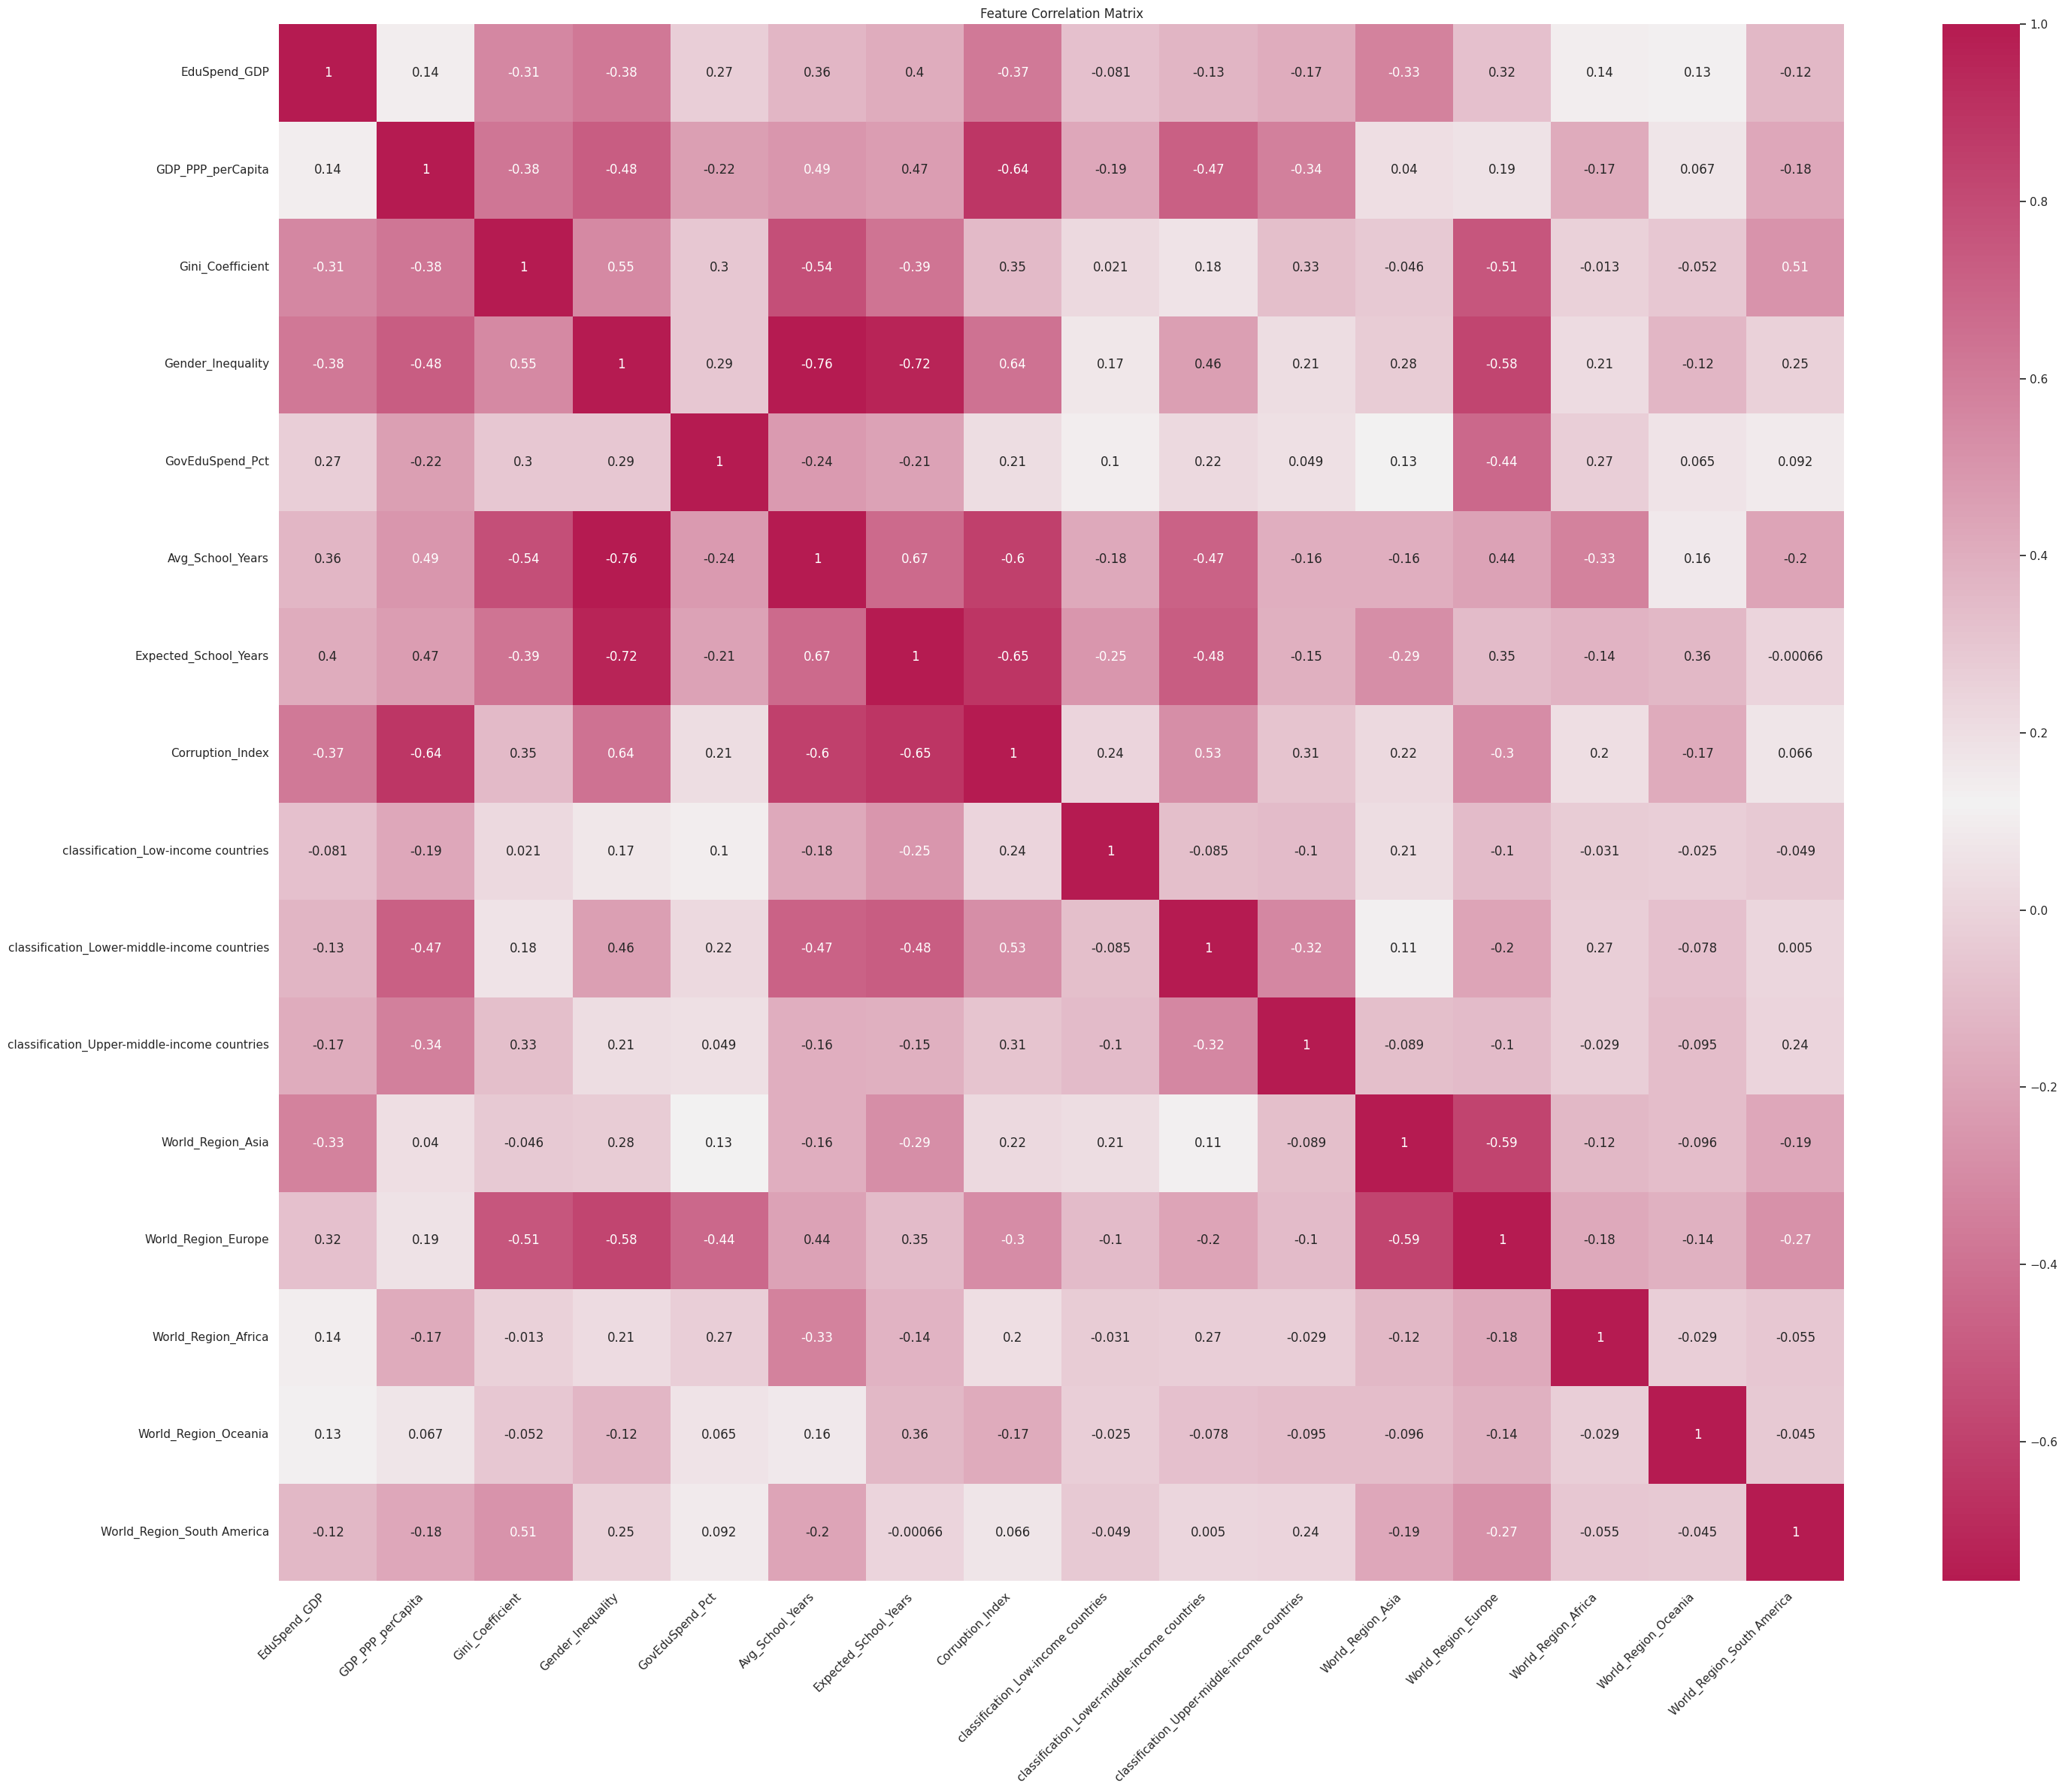

In [18]:
import seaborn as sns

# color palette to make both +1 and -1 correlation red, 0 white
# it is to see correlation more clearly by looking at the darkness
rwr = sns.diverging_palette(
    h_neg=0, h_pos=0,
    s=90,
    l=40,
    center="light",
    as_cmap=True
)


#sns.heatmap(data, cmap=rwr, center=0)

corr = df_multicol.corr()

plt.figure(figsize=(30, 24))

sns.heatmap(
    corr,
    annot=True,
    xticklabels=corr.columns,
    yticklabels=corr.columns,
     cmap= rwr,

)


plt.title("Feature Correlation Matrix")
plt.xticks(rotation=45, ha='right')
plt.yticks()
plt.tight_layout()

plt.show()


* From the correlation matrix pairwise correlations are below 0.8 so they seem acceptable.

* Now I will look at VIF to see more clearly if there is multicollinarity.

In [19]:
df_multicol = df.drop(columns=['PISA_Total_Average'])
# Calculate VIF
X = df_multicol
X = sm.add_constant(X)  # statsmodels requires adding constant manually

vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif_data

,feature,VIF
0,const,20.233552
1,EduSpend_GDP,2.060300
2,GDP_PPP_perCapita,3.786529
3,Gini_Coefficient,3.292586
4,Gender_Inequality,4.243949
5,GovEduSpend_Pct,1.946091
6,Avg_School_Years,6.322933
7,Expected_School_Years,6.489518
8,HDI,34.099189
9,Corruption_Index,3.657281


* From VIF results, every other column is below 10 while HDI is quite high with 34.1.

* I tried combining with other columns but VIF was still high, best approach seems to be dropping HDI column that is why I will drop and calculate VIF again.

In [20]:
df_multicol = df_multicol.drop(columns=[
    'HDI'
  ])

# Calculate VIF
X = df_multicol
X = sm.add_constant(X)  # statsmodels requires adding constant manually
X = X.drop(columns='const') # dropping const since it will not be usefull

vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

vif_data

#df_multicol.head()


,feature,VIF
0,EduSpend_GDP,2.032628
1,GDP_PPP_perCapita,2.525176
2,Gini_Coefficient,2.739586
3,Gender_Inequality,3.917655
4,GovEduSpend_Pct,1.872258
5,Avg_School_Years,3.230639
6,Expected_School_Years,3.551761
7,Corruption_Index,3.140862
8,classification_Low-income countries,1.761095
9,classification_Lower-middle-income countries,4.681397


* VIF are all below 5, therefore checking for multicollinearity is finished here.

---


### Applying Linear Regression

In [21]:
df_multicol.head()

,EduSpend_GDP,GDP_PPP_perCapita,Gini_Coefficient,Gender_Inequality,GovEduSpend_Pct,Avg_School_Years,Expected_School_Years,Corruption_Index,classification_Low-income countries,classification_Lower-middle-income countries,classification_Upper-middle-income countries,World_Region_Asia,World_Region_Europe,World_Region_Africa,World_Region_Oceania,World_Region_South America
0,-0.856356,-1.068267,-0.763326,0.184493,-0.607354,-0.611713,-1.734980,1.340299,0,1,0,0,1,0,0,0
1,-1.078962,-1.016115,-0.595039,0.078031,-0.607354,-0.526086,-1.441734,1.357391,0,1,0,0,1,0,0,0
2,-1.038373,-0.957632,-0.731048,-0.040955,-0.757809,-0.442518,-0.929942,1.278768,0,1,0,0,1,0,0,0
3,-0.832733,-0.885472,-0.824459,-0.448015,-0.665533,-0.311499,-0.579946,1.394993,0,0,1,0,1,0,0,0
4,-0.948702,-0.847682,-0.932624,-0.416702,-0.543714,-0.064737,0.464697,1.425759,0,0,1,0,1,0,0,0


* Feature columns are displayed.

---

Validation Set MSE: 0.25


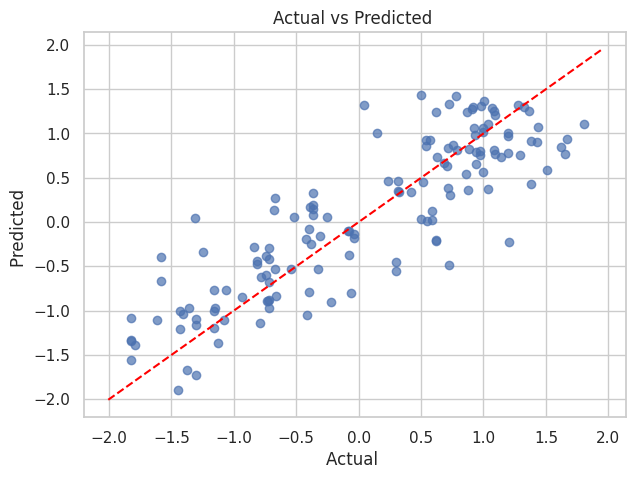

In [35]:
# updated from recitation 11 codes
X = df_multicol
y = df['PISA_Total_Average']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55)

# Train and evaluate
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f"Validation Set MSE: {mse:.2f}")



# Plot actual vs predicted scores
plt.figure(figsize=(7, 5))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--')
plt.xlabel('Actual ')
plt.ylabel('Predicted ')
plt.title('Actual vs Predicted ')
plt.grid(True)
plt.show()

In [33]:
# 5-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=55)
cv_scores = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')

# Convert negative MSE to positive
cv_mse_scores = -cv_scores
print("5-Fold CV MSE Scores:", cv_mse_scores)
print(f"Average CV MSE: {cv_mse_scores.mean():.2f}")

5-Fold CV MSE Scores: [0.24605539 0.24839748 0.29527574 0.30576158 0.27827798]
Average CV MSE: 0.27


In [34]:
# Leave-One-Out Cross-Validation
loo = LeaveOneOut()
cv_scores_loo = cross_val_score(model, X, y, cv=loo, scoring='neg_mean_squared_error')

# Convert to positive MSE
mse_loo = -cv_scores_loo
print(f"Average LOOCV MSE: {mse_loo.mean():.2f}")

Average LOOCV MSE: 0.27


* LOO and K-fold has less error compared to dividing data into into 80-20% train test data.